1. Analyse des préoccupations en santé mentale à travers les conversations  
**Objectif** : Identifier les principaux sujets abordés dans les conversations en utilisant des techniques de clustering (LDA, NMF, BERTopic).  
Pourquoi c'est intéressant ? Cela permet de mieux comprendre les préoccupations fréquentes et d’adapter les ressources d’aide.

In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np


import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  
from sklearn.model_selection import train_test_split


In [72]:

data = pd.read_parquet("hf://datasets/NickyNicky/nlp-mental-health-conversations/data/train-00000-of-00001.parquet")

In [76]:
data.isna().sum()

# Ensure text data is in string format
data['Context'] = data['Context'].astype(str)

#### Nettoyage des textes

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# def clean_text(text):
#     return [
#         token.lemma_.lower()
#         for token in nlp(text)
#         if (
#             not token.is_stop and
#             not token.is_punct and
#             not token.is_space and
#             not token.like_num and
#             not token.like_url
#         )
#     ]

# # Apply cleaning function to the 'Content' column
# data['Tokens'] = data["Context"].apply(clean_text)

In [101]:
import contractions #  Étendre les contractions avant de nettoyer le texte . i'm -> i am 

def expand_contractions(text):
    return contractions.fix(text)

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if not isinstance(text, str):  # Vérifier si le texte est une string
        return ""  # Retourner une chaîne vide si None ou autre type
    text = text.lower()  # Minuscule
    text = contractions.fix(text)
    text = re.sub(r'\d+', '', text)  # Supprimer les nombres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Supprimer les stopwords
    return " ".join(words)

data["Context_cleaned"] = data["Context"].apply(clean_text)
data["Response_cleaned"] = data["Response"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibrah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
vect = CountVectorizer(stop_words='english',max_features=500,lowercase=True, min_df=20, encoding='utf-8')
X = vect.fit_transform(data["Response_cleaned"])
df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())


Mots les plus frequents 

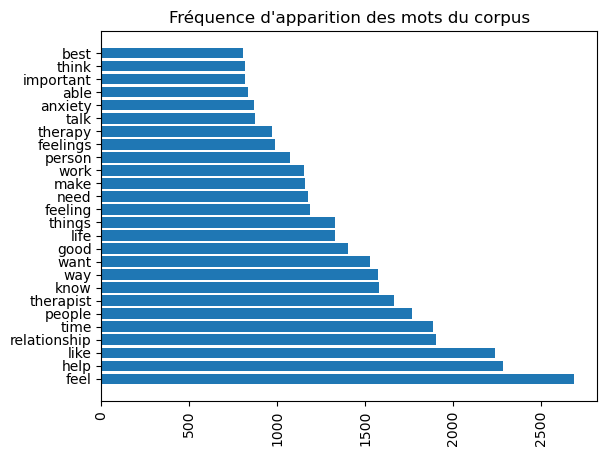

In [103]:
freqs = [(word, X.getcol(idx).sum()) for word, idx in vect.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.barh([x[0] for x in freqs[:26]], [x[1] for x in freqs[:26]])
plt.xticks(rotation=90)
plt.title("Fréquence d'apparition des mots du corpus")
plt.show()

Nuage des mots 

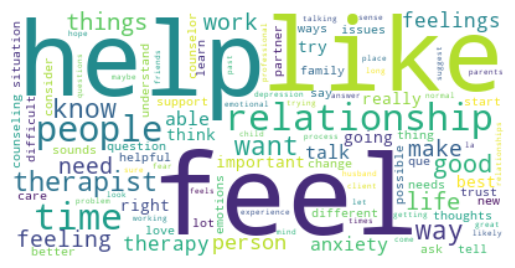

In [104]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Detection des thématiques 
  - Non-negative Matrix Factorization

In [105]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=6, random_state=123, init="nndsvda", beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=1)
# train the model and use it to return a matrix where each row represents the topic distribution for a document in the original dataset
start_time = time.time()
nmf_matrix = nmf.fit_transform(X)
print("Temps de calcul :", time.time() - start_time)


terms = vect.get_feature_names_out()
lda_components=nmf.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Temps de calcul : 0.32503509521484375
Topic 0:  ['like', 'help', 'people', 'want', 'things', 'time', 'know', 'make', 'good', 'need']
Topic 1:  ['que', 'la', 'en', 'tu', 'el', 'es', 'para', 'te', 'si', 'una']
Topic 2:  ['therapist', 'client', 'therapy', 'counselor', 'clients', 'help', 'end', 'counseling', 'work', 'good']
Topic 3:  ['relationship', 'partner', 'need', 'want', 'person', 'work', 'relationships', 'couples', 'trust', 'boyfriend']
Topic 4:  ['feel', 'feeling', 'therapist', 'way', 'like', 'feelings', 'people', 'emotions', 'know', 'comfortable']
Topic 5:  ['thoughts', 'anxiety', 'thought', 'help', 'way', 'negative', 'work', 'positive', 'brain', 'scary']


Fonction pour afficher les thématiques 

In [61]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

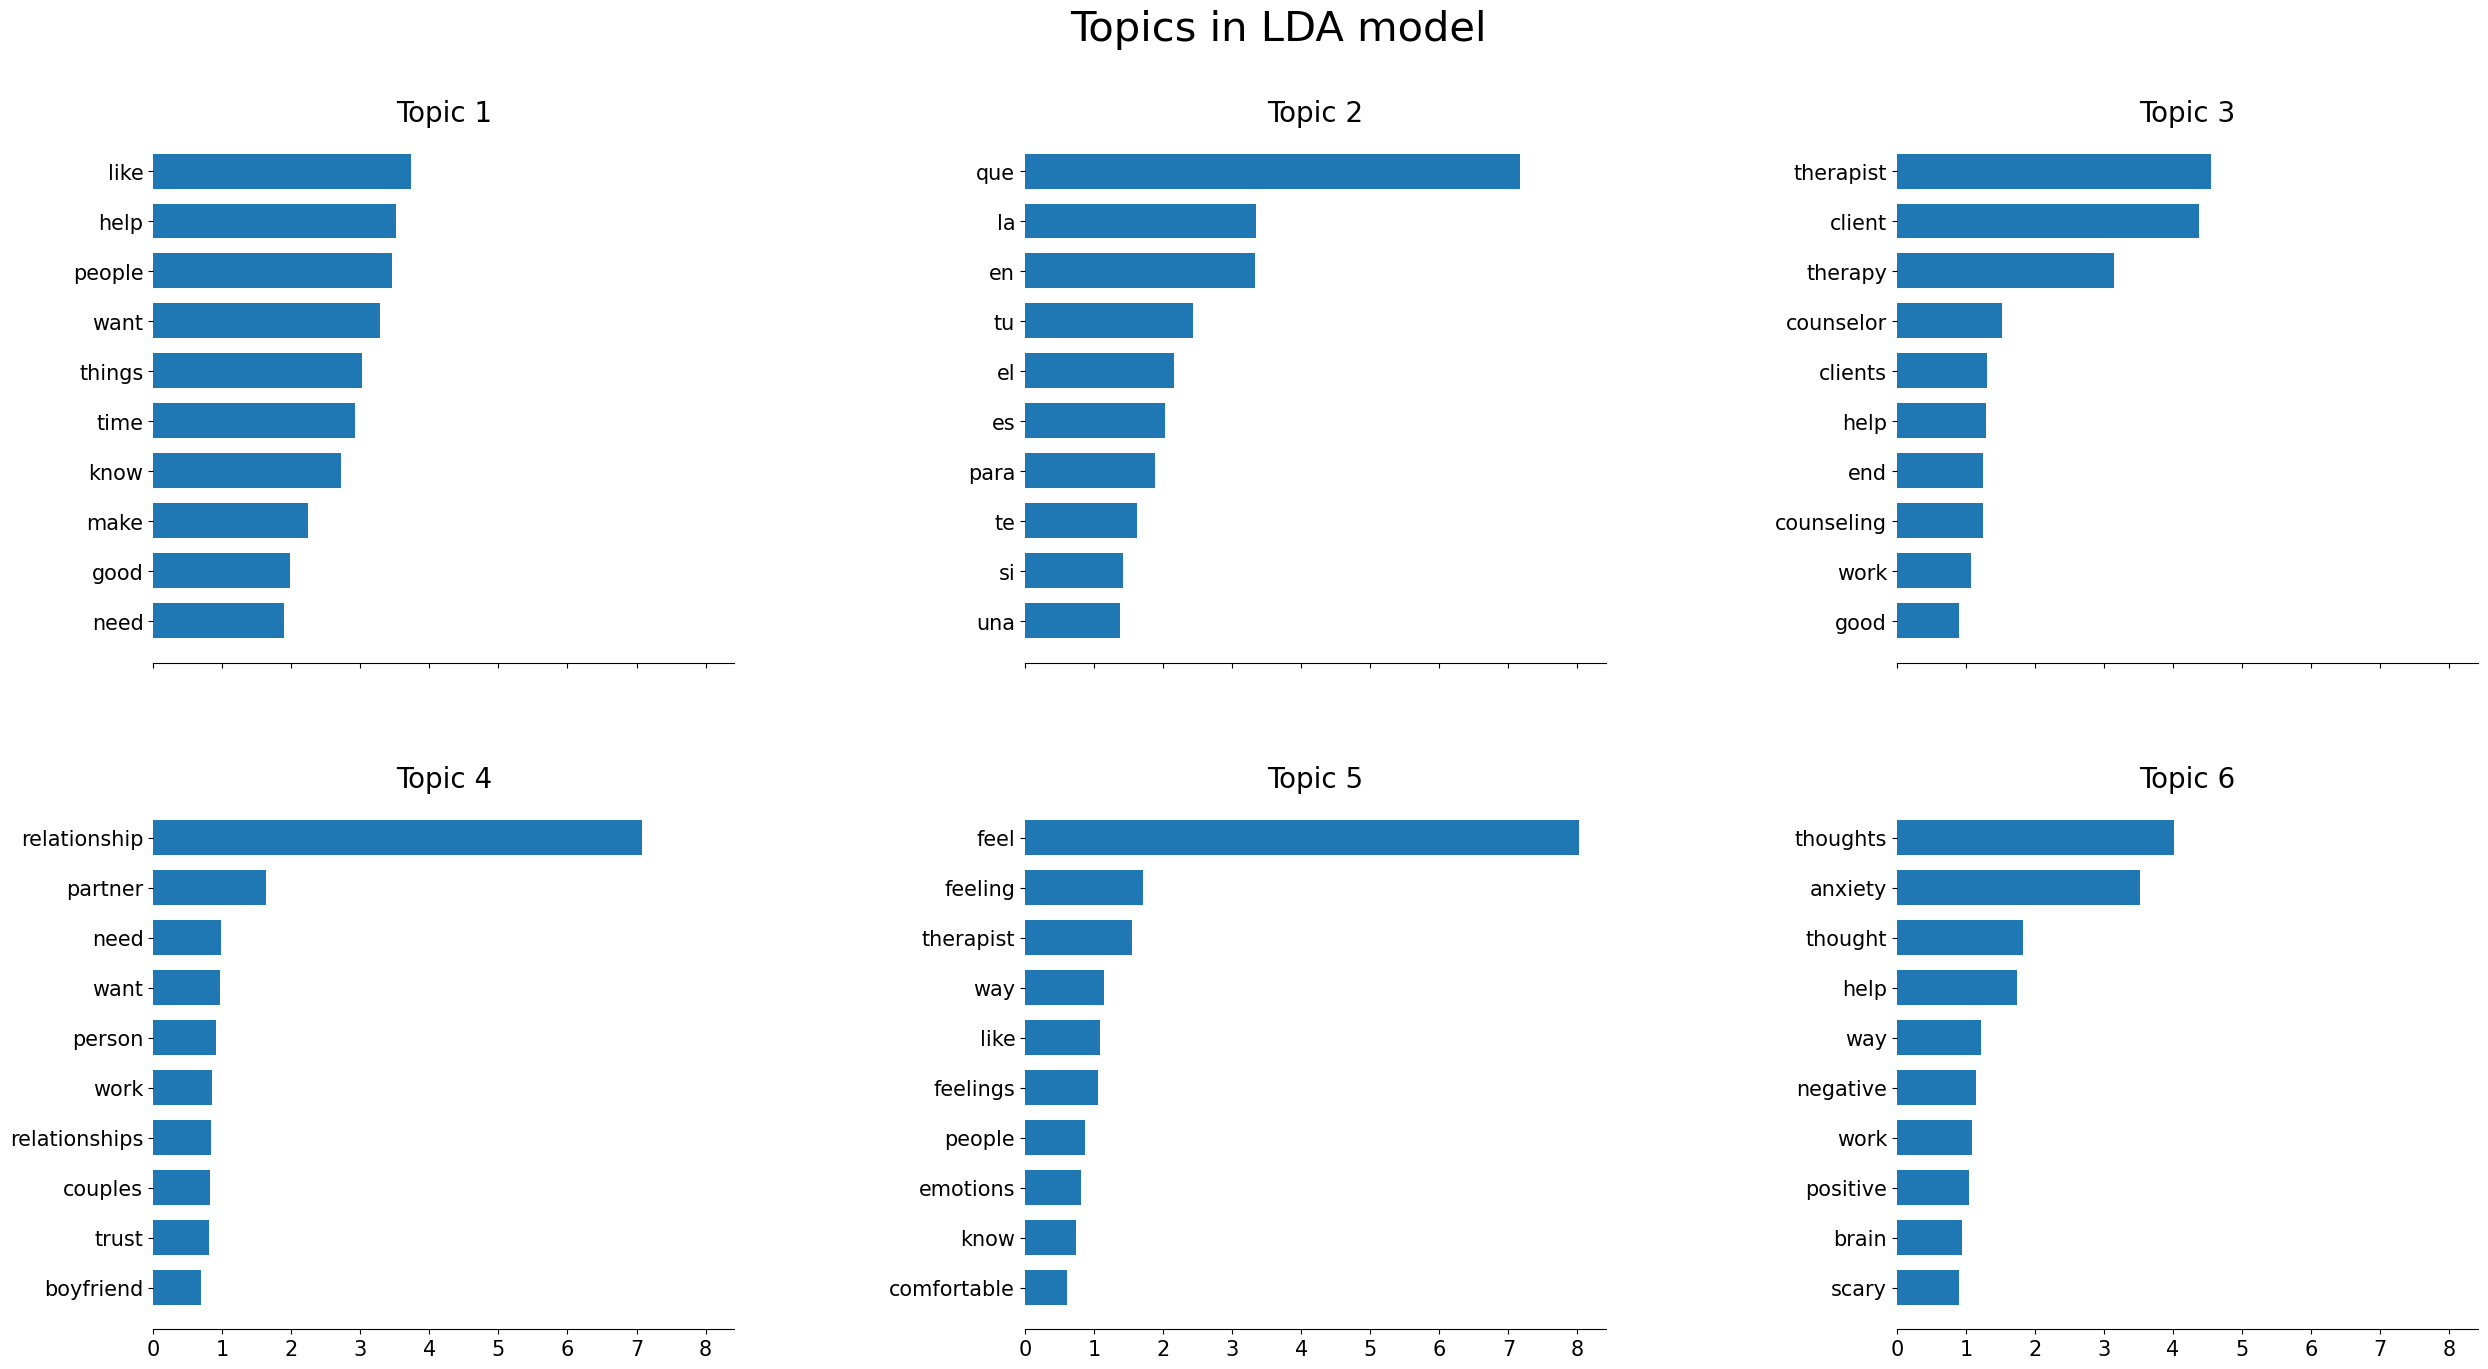

In [106]:
n_top_words = 10
plot_top_words(nmf, terms, n_top_words, "Topics in LDA model")

Clustering 

In [90]:
from sklearn.cluster import KMeans
nclusters = 6
kmeans = KMeans(n_clusters=nclusters, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
from sklearn.metrics import silhouette_score
silhouette_score(X, labels=y_kmeans) # score de silhouette

0.10811363682775088

In [91]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=235, init='random').fit_transform(X)

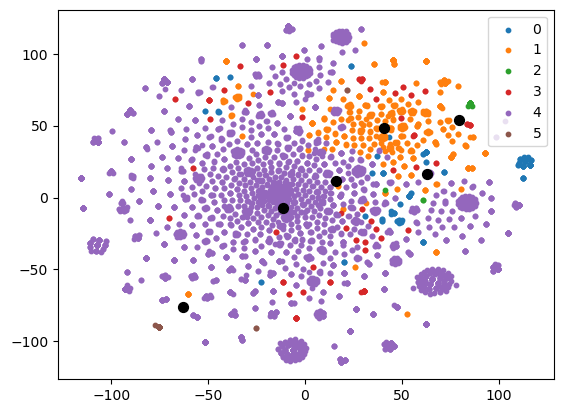

In [92]:
centroids_tsne = []
for i in range(0, nclusters):
    x = X_tsne[y_kmeans==i, 0]
    y = X_tsne[y_kmeans==i, 1]
    x_center = x.mean()
    y_center = y.mean()
    plt.scatter(x, y, label = i, s=10)
    centroids_tsne.append((x_center, y_center))
x_cent, y_cent = zip(*centroids_tsne)
plt.scatter(x_cent, y_cent, s=50, color='k')
plt.legend()
plt.show()

Cluster: 0
Titles


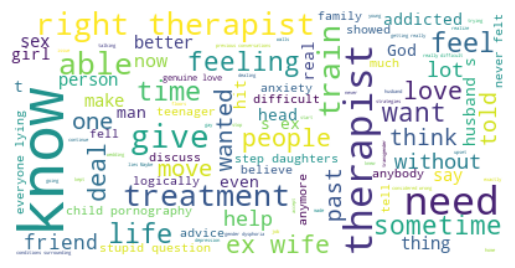

Cluster: 1
Titles


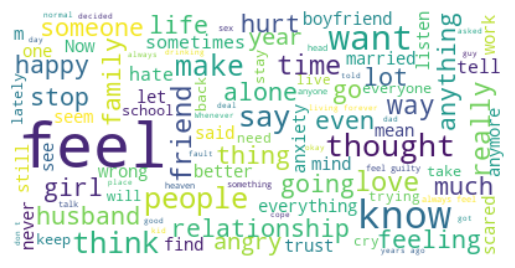

Cluster: 2
Titles


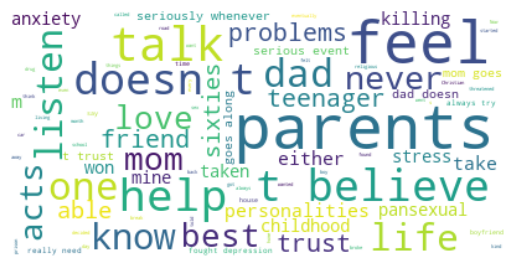

Cluster: 3
Titles


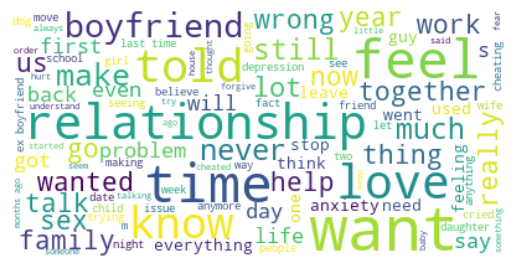

Cluster: 4
Titles


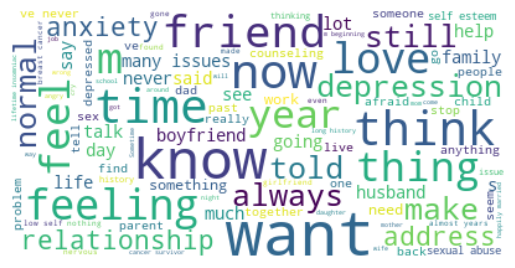

Cluster: 5
Titles


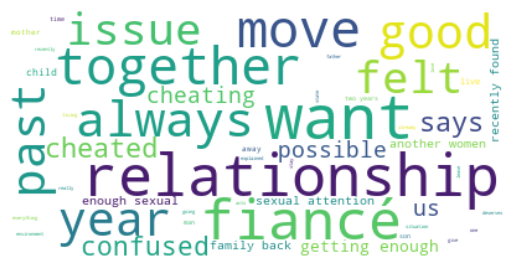

In [93]:
data["Label"] = y_kmeans
for k in range(0, nclusters):
   cl_data = data[data["Label"] == k]
   text = cl_data["Context"].str.cat(sep=' ')
   text = ' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()